In [1]:
%load_ext lab_black

In [2]:
from dateutil.relativedelta import relativedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import ceil, floor
from matplotlib.lines import Line2D

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [3]:
# Set up plotting
current_palette = sns.color_palette()
LANGUAGE_COLORS = {
    "Chinese": current_palette[0],
    "English": current_palette[1],
    "Spanish": current_palette[2],
    "Sign": current_palette[3],
    "Animal Sound": current_palette[4],
}

# Set plotting style
sns.set_style("white")

# Plot constants
WIDTH = 12
HEIGHT = 7

TITLE_SIZE = 26
AXIS_TITLE_SIZE = 20

%matplotlib inline

In [4]:
CHILD0_BIRTH_DATE = datetime.date(2016, 6, 1)
CHILD1_BIRTH_DATE = datetime.date(2017, 12, 1)
CHILD2_BIRTH_DATE = datetime.date(2019, 10, 1)

In [5]:
DEFAULT_BIRTH_DATE = CHILD2_BIRTH_DATE

In [6]:
CHILD0_COLS = ["timestamp", "word", "language", "first_use_alt"]
CHILD1_COLS = ["timestamp", "word", "language", "first_use_alt", "description"]
CHILD2_COLS = ["timestamp", "word", "description", "language", "first_use_alt"]

## Normalize the data

In [7]:
def load_data(
    file, column_names=["timestamp", "word", "language", "first_use_alt", "description"]
):
    words_df = pd.read_csv(
        file, names=column_names, header=0, parse_dates=["timestamp", "first_use_alt"]
    )

    # Google changed how the form worked in the middle of my data collection, making it very hard to enter dates,
    # so I started using the timestamp as the entry time
    words_df["first_use"] = np.where(
        words_df["first_use_alt"].notnull(),
        words_df["first_use_alt"],
        words_df["timestamp"],
    )

    # Then keep just the day, instead of the hour:minute:second, since we do not have that level of precision and it makes grouping harder
    words_df["first_use"] = words_df["first_use"].dt.date

    # Sort by first use
    words_df = words_df.sort_values("first_use")

    # Lowercase all words
    words_df["word"] = words_df["word"].str.lower().str.strip()

    # Remove paranthetical remarks
    words_df["word"] = words_df["word"].str.split("(").str[0].str.strip()

    # Save the first duplicate, remove the rest
    words_df = words_df.drop_duplicates(subset=["language", "word"])
    words_df = words_df.reset_index(drop=True)

    # Sort by first_use date and then cumulative count
    words_df = words_df.sort_values("first_use")
    words_df["count"] = words_df.groupby("language").cumcount()
    # `.cumcount()` starts from 0, but we want the first word to be 1
    words_df["count"] += 1

    # Remove blank rows
    words_df = words_df.dropna(axis="index", subset=["word"])

    return words_df

In [8]:
def generate_language_day_count_df(words_df):
    # Select just the columns we need to plot
    language_day_count_df = words_df[["first_use", "count", "language"]].reset_index(
        drop=True
    )

    # Add a common start and end point
    before_first_day = DEFAULT_BIRTH_DATE
    min_day = words_df["first_use"].min()
    max_day = words_df["first_use"].max()
    for language in language_day_count_df["language"].unique():
        is_correct_language = language_day_count_df["language"] == language
        max_count = language_day_count_df[is_correct_language]["count"].max()
        new_df = pd.DataFrame(
            [(min_day, 0, language), (max_day, max_count, language)],
            columns=["first_use", "count", "language"],
        )
        language_day_count_df = language_day_count_df.append(new_df)

    return language_day_count_df.sort_values(["first_use", "count"]).reindex()

In [9]:
theo_words_df = load_data("./theo_words.csv", column_names=CHILD0_COLS)
cory_words_df = load_data("./cory_words.csv", column_names=CHILD1_COLS)
ash_words_df = load_data("./ash_words.csv", column_names=CHILD2_COLS)

In [10]:
# Adjust dates as the if he were born on the same day as Ash
theo_age_difference = DEFAULT_BIRTH_DATE - CHILD0_BIRTH_DATE
cory_age_difference = DEFAULT_BIRTH_DATE - CHILD1_BIRTH_DATE

for datecol in ("first_use", "first_use_alt"):
    theo_words_df[datecol] = theo_words_df[datecol] + theo_age_difference
    cory_words_df[datecol] = cory_words_df[datecol] + cory_age_difference

In [11]:
theo_language_day_count_df = generate_language_day_count_df(theo_words_df)
cory_language_day_count_df = generate_language_day_count_df(cory_words_df)
ash_language_day_count_df = generate_language_day_count_df(ash_words_df)

# Plotting Functions

In [12]:
def word_coordinates(df, count_df, word, language):
    """Return the timestamp of first useage, and the number of words known in
    the language at the time, for a given word.
    """
    correct_langauge = df["language"] == language

    compare_word = word.lower()
    correct_word = df["word"].str.contains(compare_word)

    filtered = df[correct_langauge & correct_word]
    timestamp = filtered["first_use"]

    # Join on the timestamp
    merged = pd.merge(filtered, count_df, on=["first_use", "language"])

    return timestamp.values[0], merged["count_y"].values[0]

In [13]:
def age_to_timestamp(age):
    """Returns a Timestamp for when Theo turned a specific age in months."""
    born = DEFAULT_BIRTH_DATE
    current = born + relativedelta(months=age)

    return current

In [14]:
def timestamp_to_age(timestamp):
    delta = timestamp - DEFAULT_BIRTH_DATE
    return delta.days

In [15]:
def draw_age_tick_labels(ax, first=11, until=36):
    """ """
    # Set the major ticks as dates
    ages = list(range(first, until))
    major_ticks = np.array([age_to_timestamp(age) for age in ages])
    ax.set_xticks(major_ticks)

    # Read back the x-values of the major ticks
    major_ticks_values = np.array(ax.get_xticks())

    # Put the minor ticks halfway between the majors
    half = (major_ticks_values[1] - major_ticks_values[0]) / 2
    minor_ticks = major_ticks_values + half
    ax.set_xticks(minor_ticks, minor=True)

    # Create the text of the labels
    tick_labels = [str(age) for age in ages]
    # If we go up to a year, replace the months with year
    for month_count, year_str in ((12, "1 Year"), (24, "2 Years")):
        try:
            i = ages.index(month_count)
            tick_labels[i] = year_str
        except ValueError:
            continue

    # Disable major tick labels
    ax.set_xticklabels([], minor=False)
    # Set minor tick labels
    ax.set_xticklabels(tick_labels, minor=True)

In [16]:
def annotate_word(df, count_df, ax, word, language, xytext, alt_word, arrowstyle="->"):
    """Draw an annotation on the Day of Year plot."""
    # Get the x and y coordinates for the word
    x_pos, y_pos = word_coordinates(df, count_df, word, language)

    # Draw a circle at that point
    point_color = LANGUAGE_COLORS[language]
    plt.scatter(
        [x_pos],
        [y_pos],
        s=80,
        facecolors=point_color,
        edgecolors=point_color,
        linewidth=2,
        label="_nolegend_",
        zorder=2,
    )

    # Add an arrow and text annotating it
    if alt_word is not None:
        word = alt_word

    ax.annotate(
        word,
        (x_pos, y_pos),
        xytext=xytext,
        textcoords="offset points",
        arrowprops=dict(
            arrowstyle=arrowstyle, connectionstyle="arc3", color="black", linewidth=1.5
        ),
        size=16,
        color=point_color,
        zorder=3,
    )

In [17]:
def draw_bands(ax, color="0.95", alpha=1.0):
    """Add grey bands between x-axis ticks.

    Args:
        ax (matplotlib axis): The axis to draw on.
        color (matplotlib color, default "0.95"): An object that
            matplotlib understands as a color, used to set the
            color of the bands.
        alpha (float, default 1.0): A float that controls the
            transparency of the bands. 1 is opague and 0 is
            completely transparent.

    """
    ticks = ax.get_xticks(minor=False)
    x_min, x_max = ax.get_xlim()

    lefts = []
    rights = []
    # There is a more elegant way to do this, but it assumes there is always a
    # tick outside the plot range on the left and right. It seems to be true,
    # but I don't think it is guarnteed.
    for left, right in zip(ticks[:-1], ticks[1:]):
        # Sometimes the ticks are outside the plot, so keep going until we
        # find one inside the plot. Then end when we find a ticket off the
        # right side.
        if left < x_min:
            continue
        elif x_max < left:
            break
        # The tick on the left (which starts the band) can't also be a
        # right tick (which ends a band). Otherwise we would have two
        # bands next to eachother.
        elif left in rights:
            continue

        lefts.append(left)
        rights.append(right)

    for (left, right) in zip(lefts, rights):
        ax.axvspan(left, right, color=color, alpha=alpha, zorder=-2)

    # Reset the x range so that we do not have a weird empty area on the right
    # side if we have to add one last band.
    ax.set_xlim((x_min, x_max))

In [18]:
def draw_steps(ax, ldc_df, language, linewidth=2.5, alpha=1, linestyle="-", zorder=1):
    tmp_df = ldc_df[ldc_df["language"] == language]

    ax.step(
        x=tmp_df["first_use"].values,
        y=tmp_df["count"].values,
        color=LANGUAGE_COLORS[language],
        linewidth=linewidth,
        label=language,
        zorder=zorder,
        alpha=alpha,
        where="post",
        linestyle=linestyle,
    )

## Make Words in Time Plot

In [35]:
def make_compare_plot(
    ax,
    main_words_df,
    main_language_day_count_df,
    second_words_df,
    second_language_day_count_df,
    third_words_df,
    third_language_day_count_df,
    legend_loc,
):
    first_son_linestyle = "solid"
    second_son_linestyle = "dashed"
    third_son_linestyle = "dotted"
    background_alpha = 0.14
    background_linewidth = 1.8
    for i, language in enumerate(legend_loc.keys()):
        color = LANGUAGE_COLORS[language]
        linewidth = 2.5
        alpha = 1.0

        # Draw primary lines
        draw_steps(
            ax[i], main_language_day_count_df, language, linestyle=first_son_linestyle
        )
        draw_steps(
            ax[i],
            second_language_day_count_df,
            language,
            linestyle=second_son_linestyle,
        )
        draw_steps(
            ax[i],
            third_language_day_count_df,
            language,
            linestyle=third_son_linestyle,
        )

        # Draw language legendend
        x_loc, y_loc = legend_loc[language]
        ax[i].text(
            x_loc,
            y_loc,
            language,
            color=color,
            fontsize=20,
            transform=ax[i].transAxes,
            horizontalalignment="left",
            verticalalignment="center",
        )

    # Set titles
    ax[2].set_ylabel("Words Spoken", fontsize=AXIS_TITLE_SIZE)
    ax[-1].set_xlabel("Age (Months)", fontsize=AXIS_TITLE_SIZE)

    # Custom Legend
    custom_lines = [
        Line2D([0], [0], color="Black", lw=linewidth, linestyle=first_son_linestyle),
        Line2D([0], [0], color="Black", lw=linewidth, linestyle=second_son_linestyle),
        Line2D([0], [0], color="Black", lw=linewidth, linestyle=third_son_linestyle),
    ]

    leg = ax[0].legend(
        custom_lines,
        ["Sebastian", "Cornelius", "Theodore"],
        fontsize=20,
        frameon=True,
        loc="upper left",
    )

    frame = leg.get_frame()
    frame.set_linewidth(1)
    frame.set_alpha(1)
    frame.set_facecolor("white")
    frame.set_edgecolor("black")

    # Plot the gird and grey month bands
    # We need to set the age bands for the tick labels using the maximum of the data
    max_age_in_months = max(
        (
            ceil(timestamp_to_age(main_language_day_count_df["first_use"].max()) / 30),
            ceil(
                timestamp_to_age(second_language_day_count_df["first_use"].max()) / 30
            ),
            ceil(timestamp_to_age(third_language_day_count_df["first_use"].max()) / 30),
        )
    )
    min_age_in_months = (
        min(
            (
                floor(
                    timestamp_to_age(main_language_day_count_df["first_use"].min()) / 30
                ),
                floor(
                    timestamp_to_age(second_language_day_count_df["first_use"].min())
                    / 30
                ),
                floor(
                    timestamp_to_age(third_language_day_count_df["first_use"].min())
                    / 30
                ),
            )
        )
        - 1  ## Just to give some extra room on the left
    )
    plt.minorticks_on()
    for a in ax:
        draw_age_tick_labels(a, first=min_age_in_months, until=max_age_in_months)
        a.tick_params(axis="y", which="major", labelsize=15)
        a.tick_params(axis="x", which="minor", labelsize=15)
        a.grid(True)
        draw_bands(a, color="0.97")

11 29


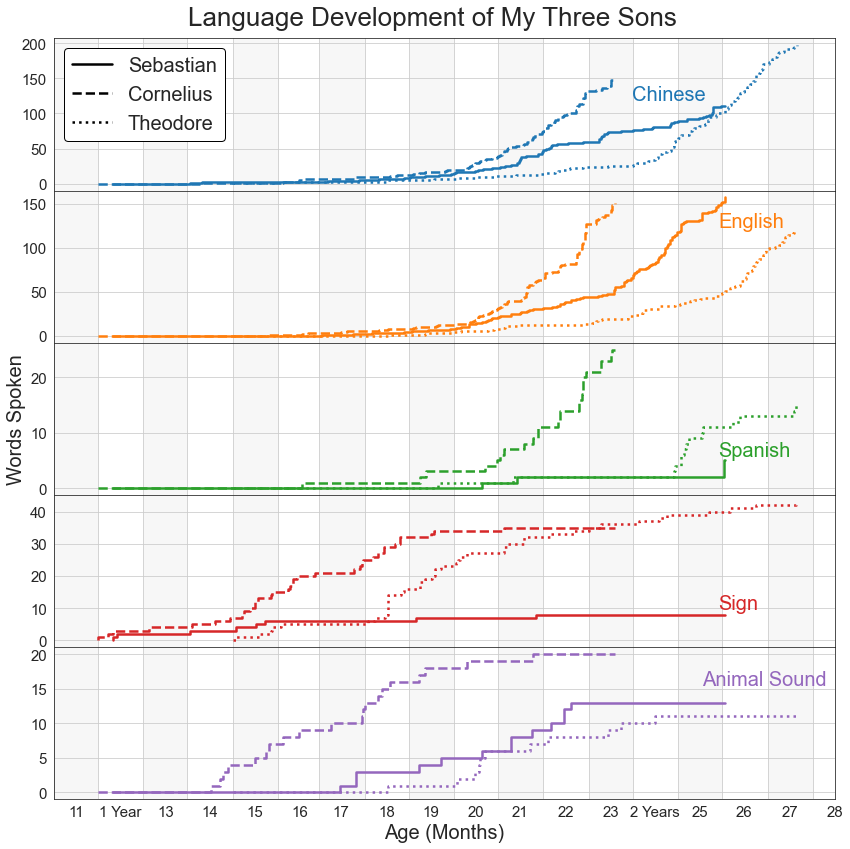

In [36]:
languages = ("Chinese", "English", "Spanish", "Sign", "Animal Sound")

fig, ax = plt.subplots(len(languages), 1, figsize=(WIDTH + 2, WIDTH + 2), sharex=True)
fig.subplots_adjust(hspace=0)

make_compare_plot(
    ax,
    ash_words_df,
    ash_language_day_count_df,
    cory_words_df,
    cory_language_day_count_df,
    theo_words_df,
    theo_language_day_count_df,
    {
        "Chinese": (0.74, 0.63),
        "English": (0.85, 0.80),
        "Spanish": (0.85, 0.29),
        "Sign": (0.85, 0.29),
        "Animal Sound": (0.83, 0.79),
    },
)

fig.text(
    0.5,
    0.9,
    "Language Development of My Three Sons",
    fontsize=TITLE_SIZE,
    verticalalignment="center",
    horizontalalignment="center",
)


fig.patch.set_alpha(1)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig(
        f"/tmp/child0_vs_child1_vs_child2_total_words_linear.{ext}",
        bbox_inches="tight",
    )